## Introduction

In this exercise, we will use regression techniques on housing market in the US. The dataset used is a Kaggle dataset which can be found [here.](https://www.kaggle.com/code/srivnaman/advanced-regression-models/data)

We will go through data cleaning, investigate distributions, exploratory data analysis, and then finally modeling using several regression models. 

The dataset consists of these fields: 
* Price
* Bed
* Bath
* Acre Lot
* House Size
* Address
* Zipcode
* City
* State

### Sections

* [Importing Packages and Loading Data](#importing-packages-and-loading-data)
* [Data Cleaning](#data-cleaning)
    * [Duplicate and Nulls](#duplicate-nulls)
    * [Unique Values](#unique_values)
    * [Converting Numbers to Strings](#converting)
* [Plotting](#plotting)
    * [Boxplot](#boxplots)
    * [Histograms](#histograms)
* [Exploratory Data Analysis](#eda)
* [Modeling](#modeling)
    * [Decision Trees](#dt)
    * [Random Forest](#rf)
    * [Extra Trees](#et)
* [Conclusion](#conclusion)

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.patches as mpatches
sns.set_theme(style="dark")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,cross_val_score,KFold,StratifiedKFold,train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score


import warnings
warnings.filterwarnings("ignore")

# Finding path of input file
path = os.getcwd() + '/Data/'
# Finding filename
filename = [f for f in os.listdir(path) if '.csv' in f][0]
# Loading the data into dataframe
df = pd.read_csv(path + filename,low_memory=False)
# df info
print (df.shape)
df.info()

(100000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        100000 non-null  object 
 1   price         100000 non-null  int64  
 2   bed           75050 non-null   float64
 3   bath          75112 non-null   float64
 4   acre_lot      85987 non-null   float64
 5   full_address  100000 non-null  object 
 6   street        99916 non-null   object 
 7   city          99948 non-null   object 
 8   state         100000 non-null  object 
 9   zip_code      99805 non-null   float64
 10  house_size    75082 non-null   float64
 11  sold_date     28745 non-null   object 
dtypes: float64(5), int64(1), object(6)
memory usage: 9.2+ MB


In [2]:
df.head()

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,for_sale,105000,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,for_sale,80000,4.0,2.0,0.08,"Km 78 9 Carr # 135, Adjuntas, PR, 00601",Km 78 9 Carr # 135,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,for_sale,67000,2.0,1.0,0.15,"556G 556-G 16 St, Juana Diaz, PR, 00795",556G 556-G 16 St,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,for_sale,145000,4.0,2.0,0.10,"R5 Comunidad El Paraso Calle De Oro R-5 Ponce,...",R5 Comunidad El Paraso Calle De Oro R-5 Ponce,Ponce,Puerto Rico,731.0,1800.0,NaN
4,for_sale,65000,6.0,2.0,0.05,"14 Navarro, Mayaguez, PR, 00680",14 Navarro,Mayaguez,Puerto Rico,680.0,NaN,NaN


### Data Cleaning

#### Missing Values

The following fields have more than 10% missing value:

* Bed (10% missing)
* Bath (12% missing)
* Acre Lot (29% missing)
* House Size (32% missing)
* Sold Date (50.6% missing)

Will look to see which of these fields will be dropped or imputed

In [3]:
mv = df.isnull().sum().sort_values(ascending=False).to_frame('Missing Values')
mv['% missing'] = round(mv['Missing Values']/df.shape[0]*100)
mv = mv.merge(df.nunique().to_frame('Unique Values'),right_index=True,left_index=True).sort_index()
describe = df.describe().T
mv = mv.merge(describe,how='left',left_index=True,right_index=True)
mv.loc[mv['count'].notnull(),'Type'] = 'number'
mv['Type'].fillna('string',inplace=True)
mv['mean'] = mv['mean'].round(3)

mv = mv.drop(['count'],axis=1)
mv

,Missing Values,% missing,Unique Values,mean,std,min,25%,50%,75%,max,Type
acre_lot,14013,14.0,1613,13.613,8.401439e+02,0.0,0.19,0.51,2.0,100000.0,number
bath,24888,25.0,24,2.495,1.573324e+00,1.0,2.00,2.00,3.0,56.0,number
bed,24950,25.0,28,3.701,2.091372e+00,1.0,3.00,3.00,4.0,86.0,number
city,52,0.0,525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
full_address,0,0.0,14719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
house_size,24918,25.0,3578,2180.082,5.625349e+03,100.0,1200.00,1728.00,2582.0,1450112.0,number
price,0,0.0,1999,438365.550,1.015773e+06,445.0,125000.00,265000.00,474900.0,60000000.0,number
sold_date,71255,71.0,3604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
state,0,0.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
status,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string


In [4]:
# List of columns with 10% missing values
for c in mv[mv['% missing']>10].index.values.tolist():
    try:
        print (c)
    except:
        pass

acre_lot
bath
bed
house_size
sold_date


In [5]:
# Dropping Sold_Date
df = df.drop(['sold_date'],axis=1)

#### Missing Values

In [6]:
# Acres/House Size missing 
df[(df['acre_lot'].isnull()) & (df['house_size'].isnull())].shape

(248, 11)

In [7]:
# Bed/Bath missing
df[(df['bed'].isnull()) & (df['bath'].isnull())].shape

(24664, 11)

In [8]:
# keeping acre and house size not null because these are important for finding price
df1 = df[(df['acre_lot'].notnull()) & (df['house_size'].notnull())]
df1 = df1[~((df1['bed'].isnull()) & (df1['bath'].isnull()))].reset_index(drop=True)
df1 = df1.drop(['status'],axis=1)

##### Zipcode

In [9]:
df1[df1['zip_code'].isnull()]['full_address'].value_counts()

3-S 51 Calle # 44, Toa Alta, PR                        20
Lot 5 Sr 149 Km 11, Ciales, PR                         12
3117 Espada, Ponce, PR                                 11
Villas De Loiza D 17 2 St Loiza Pr # 772, Loiza, PR    11
Carr 910 Km 2 0 Parcel B, Naguabo, PR                   5
14 Elm St, Philmont, NY                                 3
153 Celis Perez, Fajardo, PR                            2
Name: full_address, dtype: int64

##### Filling in Zipcode for mainland US

In [16]:
from geopy.geocoders import Nominatim
# initialize Nominatim API 
geolocator = Nominatim(user_agent="geoapiExercises")
import time
add_dic = {}

null_zipcode = df1[df1['zip_code'].isnull()]['full_address'].unique().tolist()
null_zipcode_us = [i for i in null_zipcode if ('VI' not in i) and ('PR' not in i)]
null_zipcode_us

def get_zipcode(place):
    location = geolocator.geocode(place)
    try:
        return location.address
    except:
        return ''

elm_address = get_zipcode(null_zipcode_us[0])
#whittaker_address = get_zipcode(null_zipcode_us[1])

df1.loc[df1['full_address']==null_zipcode_us[0],'zip_code'] = elm_address.split()[-3].replace(',','')

In [17]:
# Dropping null zipcode
df1 = df1[df1['zip_code'].notnull()]
#df1['zip_code'] = df1['zip_code'].apply(lambda x: str(x).replace('.0',''))
df1['zip_code'] = df1['full_address'].apply(lambda x: x.split()[-1])

##### City

In [18]:
import uszipcode
#from uszipcode import SearchEngine, SimpleZipcode, Zipcode
#search = SearchEngine()
search = uszipcode.SearchEngine()
def zipcode(x):
    try:
        city = search.by_zipcode(x).major_city
    except:
        city = np.nan
    return city

null_city_index = df1.loc[df1['city'].isnull()].index.values.tolist()
df1.loc[null_city_index,'city'] = df1.loc[null_city_index,'zip_code'].apply(zipcode)

In [19]:
zipcode_non_5 = [x for x in df1['zip_code'].unique() if len(x)<5]
df1[df1['zip_code'].isin(zipcode_non_5)]['full_address'].unique()
elm_address = get_zipcode('14 Elm St, Philmont, NY')


In [20]:
df1.loc[df1['full_address']=='14 Elm St, Philmont, NY','zip_code'] = elm_address.split()[-3]

In [21]:
df1['$/sft'] = (df1['price']/df1['house_size']).round(2)

In [22]:
df1.head()

,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,$/sft
0,105000,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,00601,920.0,114.13
1,80000,4.0,2.0,0.08,"Km 78 9 Carr # 135, Adjuntas, PR, 00601",Km 78 9 Carr # 135,Adjuntas,Puerto Rico,00601,1527.0,52.39
2,67000,2.0,1.0,0.15,"556G 556-G 16 St, Juana Diaz, PR, 00795",556G 556-G 16 St,Juana Diaz,Puerto Rico,00795,748.0,89.57
3,145000,4.0,2.0,0.10,"R5 Comunidad El Paraso Calle De Oro R-5 Ponce,...",R5 Comunidad El Paraso Calle De Oro R-5 Ponce,Ponce,Puerto Rico,00731,1800.0,80.56
4,179000,4.0,3.0,0.46,"Bo Calabazas San Sebastian, San Sebastian, PR,...",Bo Calabazas San Sebastian,San Sebastian,Puerto Rico,00612,2520.0,71.03


### Exploratory Data Analysis


* Price by zipcode

* $/sqft by zipcode

* Price by city

* $/sqft by city


Below, the zipcodes starting with 100* are based in NYC

In [23]:
price_zipcode = df1.groupby(['zip_code'])['price'].agg({np.mean, np.median,len})
price_zipcode = price_zipcode.astype(int)
price_zipcode.sort_values(by='mean',ascending=False)

,mean,median,len
zip_code,,,
06753,12997000,14995000,5
06793,6617500,7097500,4
02493,5562348,4595000,43
00960,5550000,5550000,1
01259,5281187,2272500,32
...,...,...,...
00784,87193,75000,150
00606,71567,75000,37
00782,65760,69000,50


In [24]:
sqft_zipcode = df1.groupby(['zip_code'])['$/sft'].agg({np.mean, np.median,len})
sqft_zipcode = sqft_zipcode.astype(int)
sqft_zipcode.sort_values(by='mean',ascending=False).head(10)

,mean,median,len
zip_code,,,
12504,1250,1250,1
01259,1225,469,32
06794,1220,1220,1
00960,1063,1063,1
06753,823,833,5
02835,798,614,5
01255,794,283,68
02493,703,570,43
06793,697,705,4


In [25]:
price_city = df1.groupby(['city'])['price'].agg({np.mean, np.median,len})
price_city = price_city.astype(int)
price_city.sort_values(by='mean',ascending=False).head(10)

,mean,median,len
city,,,
Weston,5562348,4595000,43
Culebra,4342250,4300000,4
Cornwall,4085521,1200000,23
Millbrook,3880521,1400000,13
New Marlborough,3384666,1049000,54
Saint John,3132787,2199000,73
Milan,2902000,1549000,4
Sandisfield,2521544,495000,68
Wellesley,2503000,1575000,15


In [26]:
sqft_city = df1.groupby(['city'])['$/sft'].agg({np.mean, np.median,len})
sqft_city = sqft_city.astype(int)
sqft_city.sort_values(by='mean',ascending=False).head(10)

,mean,median,len
city,,,
New Marlboro,1351,1351,10
Taghkanic,909,1074,7
Santurce,875,875,17
New Marlborough,872,371,54
Jamestown,798,614,5
Sandisfield,794,283,68
Craryville,758,481,18
Stafford Springs,716,716,12
Weston,703,570,43


Below we will find what the distribution of beds and baths in this dataset. Ones with more than 5 bedroom/baths, look like buildings, especially ones with more than 10 bedrooms. They will be removed from the dataset later on.

In [27]:
# bed x price
bed_price = df1.groupby('bed')['price'].mean()
bed_count = df1.groupby('bed')['price'].count()
df_bed = pd.DataFrame([bed_price,bed_count],index=['Mean','Count']).T
# It looks like there is a drop off after 6 bedrooms 

print (df1[df1['bed']<7].shape[0],df1[df1['bed']>6].shape[0])
df_bed

56142 4575


,Mean,Count
bed,,
1.0,2.506760e+05,852.0
2.0,2.798427e+05,5483.0
3.0,3.561891e+05,24820.0
4.0,5.504870e+05,16143.0
5.0,7.764157e+05,5119.0
6.0,6.229969e+05,3725.0
7.0,7.802086e+05,1504.0
8.0,7.174266e+05,1108.0
9.0,1.246936e+06,813.0


In [28]:
# bath x price
bath_price = df1.groupby('bath')['price'].mean()
bath_count = df1.groupby('bath')['price'].count()
df_bath = pd.DataFrame([bath_price,bath_count],index=['Mean','Count']).T
# It looks like there is a drop off after 5 bedrooms 

print (df1[df1['bed']<6].shape[0],df1[df1['bed']>5].shape[0])
df_bath

52417 8300


,Mean,Count
bath,,
1.0,2.182723e+05,11755.0
2.0,3.110597e+05,23725.0
3.0,5.210126e+05,14752.0
4.0,7.843332e+05,5762.0
5.0,1.130155e+06,2343.0
6.0,1.459897e+06,1161.0
7.0,2.617752e+06,436.0
8.0,2.299149e+06,327.0
9.0,1.861809e+06,208.0


In [29]:
df1.describe()

,price,bed,bath,acre_lot,house_size,$/sft
count,6.084500e+04,60717.000000,60802.000000,60845.00000,6.084500e+04,60845.000000
mean,4.960454e+05,3.972561,2.588895,5.40715,2.317325e+03,205.497249
std,1.033314e+06,2.168036,1.638644,416.97980,6.121772e+03,165.048122
min,1.000000e+04,1.000000,1.000000,0.00000,1.810000e+02,3.050000
25%,2.000000e+05,3.000000,2.000000,0.14000,1.264000e+03,113.470000
50%,3.250000e+05,3.000000,2.000000,0.31000,1.846000e+03,182.930000
75%,5.250000e+05,4.000000,3.000000,0.92000,2.770000e+03,254.230000
max,6.000000e+07,86.000000,56.000000,100000.00000,1.450112e+06,4736.840000


In [30]:
def iqr(data,col):
    # Computing IQR
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    f = data.query('(@q1 - 1.5 * @iqr) <= {} <= (@q3 + 1.5 * @iqr)'.format(col))
    print (f.shape)
    return f
# Removing more than 6 beds
df1a = df1[df1['bed']<7]
print (df1a.shape)
df1a = df1a[df1a['bath']<6]
print (df1a.shape)

df1a = iqr(df1a,'price')
#df1b = iqr(df1a,'bed')
#df1a = iqr(df1a,'bath')
df1a = iqr(df1a,'acre_lot')
df1a = iqr(df1a,'house_size')
df2 = df1a.copy()
del df2['$/sft']
#del df1a,df1b,df1c,df1d,df1e

(56142, 11)
(55179, 11)
(51878, 11)
(45783, 11)
(44373, 11)


In [31]:
df2.describe()

,price,bed,bath,acre_lot,house_size
count,44373.000000,44373.000000,44373.000000,44373.000000,44373.000000
mean,313652.039889,3.453046,2.117391,0.406770,1733.876659
std,187026.427495,1.026023,0.872074,0.394557,719.381904
min,10000.000000,1.000000,1.000000,0.000000,181.000000
25%,175000.000000,3.000000,2.000000,0.120000,1178.000000
50%,279900.000000,3.000000,2.000000,0.250000,1595.000000
75%,409900.000000,4.000000,3.000000,0.530000,2163.000000
max,950000.000000,6.000000,5.000000,1.910000,3826.000000


### Plotting

* Boxplot
* Histograms
* Heatmap
* Interactions

### Boxplots

We see that Price and Acre Lots has the most outliers. With removing beds and baths greater than 7,6 respectively, there are less outliers.

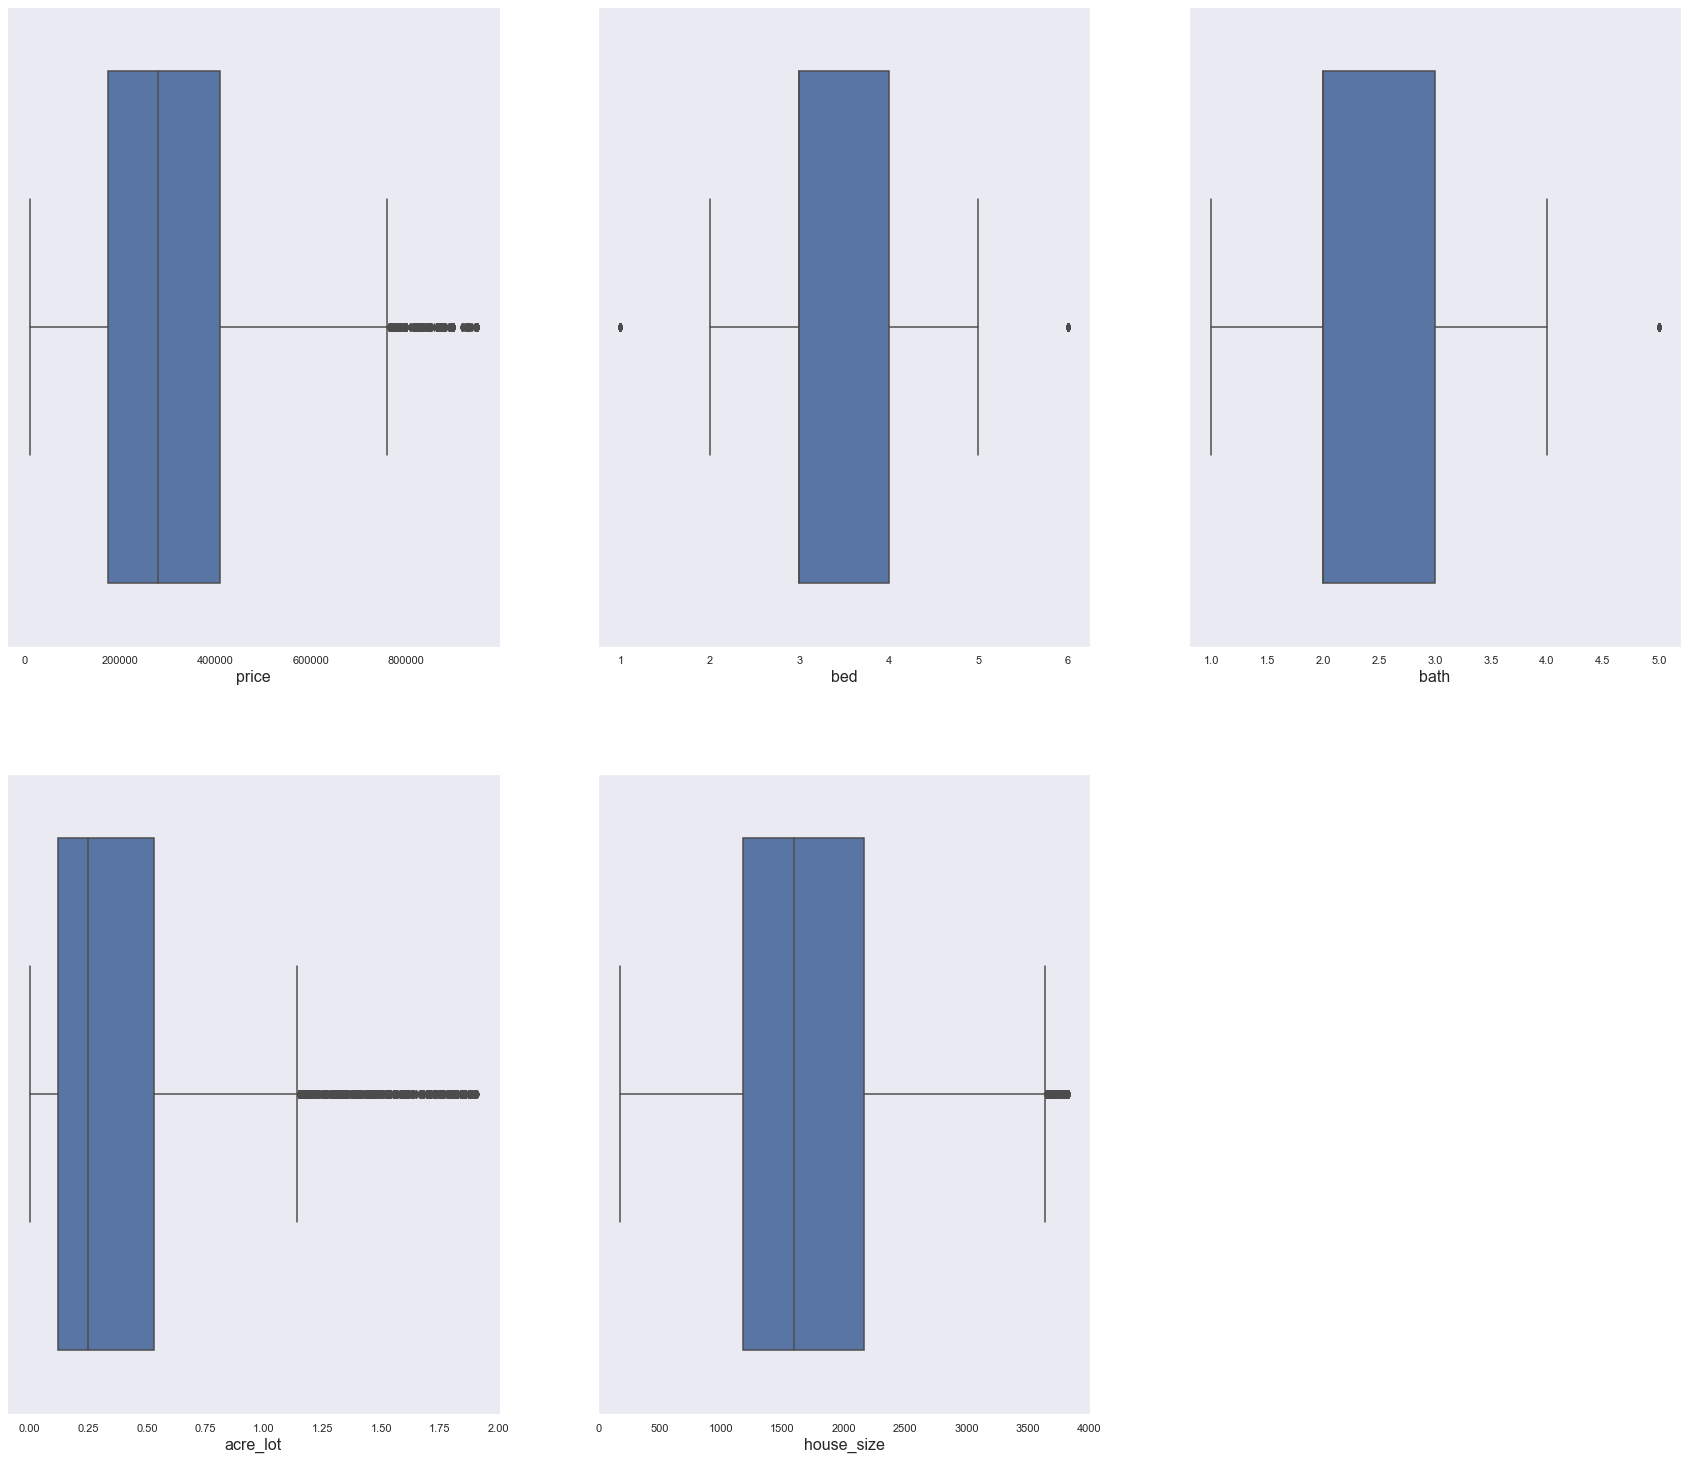

In [32]:
plt.figure(figsize=(30,40))
for i,c in enumerate(df2[['price','bed','bath','acre_lot','house_size']]):
    plt.subplot(3,3,i+1)
    sns.boxplot(data=df2,x=c)
    plt.xlabel(c,fontsize=16)

#### Histograms

* Price - The skew is more right tailed distribution
* Bed - somewhat shows normal distribution
* Bath - 2/2.5 shows the most counts
* Acre lot and house size - shows more right tailed distribution

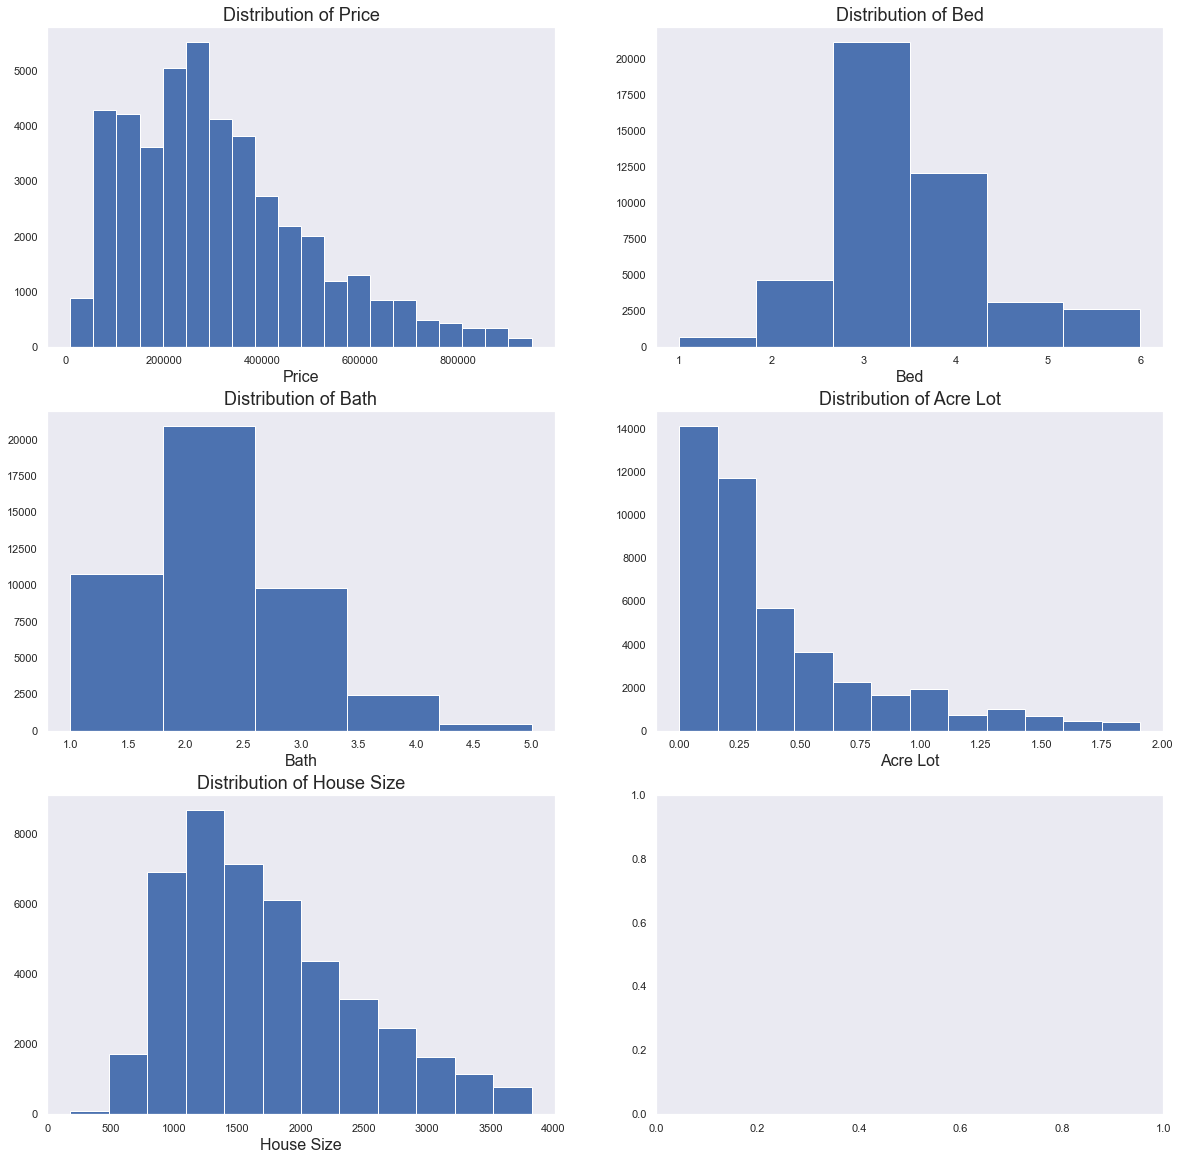

In [33]:
fig,axes = plt.subplots(3,2,figsize=(20,20))
axes[0][0].hist(x = df2['price'],bins=20,color=None)
axes[0][0].set_title("Distribution of Price",fontsize = 18)
axes[0][0].set_xlabel("Price",fontsize = 16)

axes[0][1].hist(x = df2['bed'],bins=6,color=None)
axes[0][1].set_title("Distribution of Bed",fontsize = 18)
axes[0][1].set_xlabel("Bed",fontsize = 16)

axes[1][0].hist(x = df2['bath'],bins=5,color=None)
axes[1][0].set_title("Distribution of Bath",fontsize = 18)
axes[1][0].set_xlabel("Bath",fontsize = 16)

axes[1][1].hist(x = df2['acre_lot'],bins=12,color=None)
axes[1][1].set_title("Distribution of Acre Lot",fontsize = 18)
axes[1][1].set_xlabel("Acre Lot",fontsize = 16)

axes[2][0].hist(x = df2['house_size'],bins=12,color=None)
axes[2][0].set_title("Distribution of House Size",fontsize = 18)
axes[2][0].set_xlabel("House Size",fontsize = 16)


plt.show()

### Heatmap

* price is correlated with bath and house size. I find it odd that bed isn't also correlated.
* house_size is positively correlated with bed/bath which makes sense, the more beds/bath the bigger the house size. 
* Acre_lot isn't really correlated with any of the variables. 



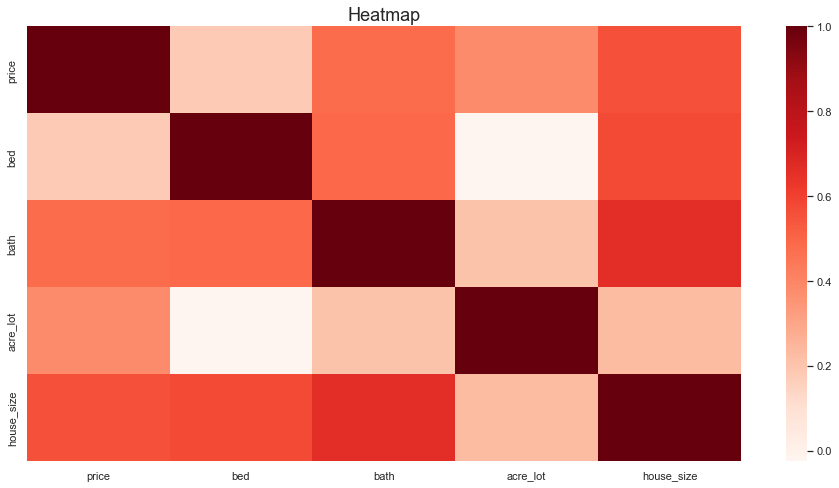

In [34]:
corr = df2.corr()
plt.figure(figsize=(16,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,cmap='Reds')
plt.title('Heatmap',fontsize=18);

### Modeling

I tried doing one hot encoding, but having that much features causing slow processing. I then used category codes to turning them into labels.
* Decision Trees
* Random Forest
* Extra Trees

In [35]:
# numbers/strings
col_numbers = [ 'bed', 'bath', 'acre_lot', 'house_size']
col_string = ['zip_code','city']
# Final Data (X)
data = df2[col_numbers+col_string]
# Y variable
y = df2['price']

In [36]:
# creating dummy for each variable and then joinin with copied df
# data1 = data.copy()
# cat_cols = []
# for var in col_string:
#     cat_list='var'+'_'+var
#     cat_list = pd.get_dummies(data1[var], prefix=var)
#     cat_cols.append(cat_list.columns.values.tolist())
#     #print (var,cat_list.shape)
#     data1=data1.join(cat_list)
# data1.shape

# col_finals = col_numbers + cat_cols[0] + cat_cols[1]


# Turning Zipcode and City into category codes
data['zipcode'] = data['zip_code'].astype('category').cat.codes
data['city1'] = data['city'].astype('category').cat.codes
data = data.drop(['zip_code','city'],axis=1).rename(columns = {'city1':'city'})

In [37]:
rs = 250

import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Pipeline for Categorical Features
categorical_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="most_frequent")),
           ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False))])

# Pipeline for Numerical Features
from sklearn.preprocessing import StandardScaler
numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())])

# Combining Categorical and Numerical Pipeline
from sklearn.compose import ColumnTransformer
# full_processor = ColumnTransformer(
#     transformers=[
#         ("numeric", numeric_pipeline, col_numbers),
#         ("categorical", categorical_pipeline, col_string)])
full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, col_numbers)])

# Apply preprocessing to df2
X_processed = full_processor.fit_transform(data)
y_processed = SimpleImputer(strategy="most_frequent").fit_transform(y.values.reshape(-1, 1))

X_processed1 = pd.DataFrame(X_processed,columns = col_numbers).join(data[['zipcode','city']].reset_index(drop=True))
X_processed = X_processed1.values

# Processed Data
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, random_state=rs,test_size=0.4)
print (X_train.shape)

(26623, 6)


#### Decision Trees

In [38]:
dm = DecisionTreeRegressor()  
dm.fit(X_train, y_train) 
predicted_dm = dm.predict(X_test)
print ("Mean Absolute Error using Decision Trees :", mean_absolute_error(y_test, predicted_dm))
#print ("R^2 Decision Trees :", r2_score(y_test,predicted_dm))
print(dm.score(X_test, y_test))


Mean Absolute Error using Decision Trees : 7528.709638550461
0.9576380728788837


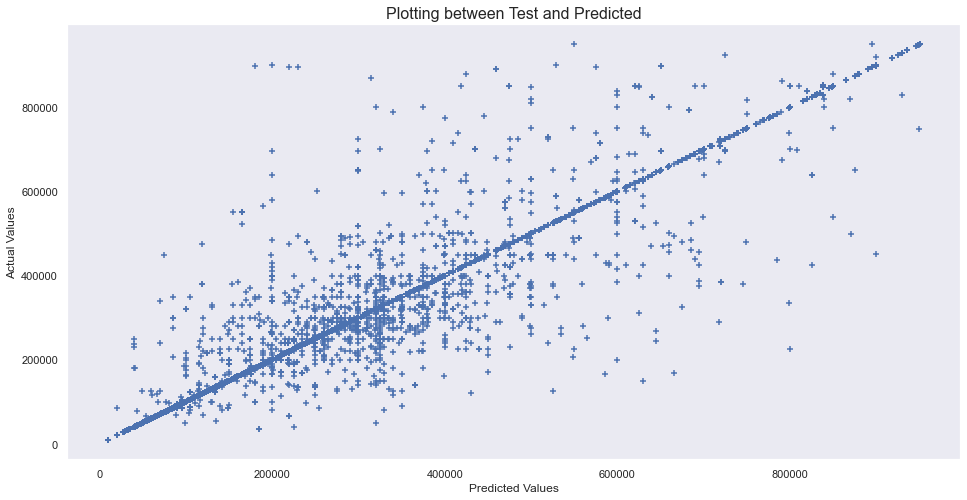

In [39]:
#print "MSE:", mean_squared_error(y_test, predicted_dm)
plt.figure(figsize=(16,8))
plt.scatter(predicted_dm, y_test, s=30, c='b', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title('Plotting between Test and Predicted',fontsize=16)
plt.show()

#### Random Forest

In [40]:
rf = RandomForestRegressor()
rf.fit(X_train , y_train )
predicted_rf = rf.predict(X_test)
print("Mean Absolute Error using Random Forest:", mean_absolute_error(y_test, predicted_rf))
#print ("R^2 Random Forest :", r2_score(y_test,predicted_rf))
print(rf.score(X_test, y_test))

Mean Absolute Error using Random Forest: 7810.003858621029
0.9712125451589149


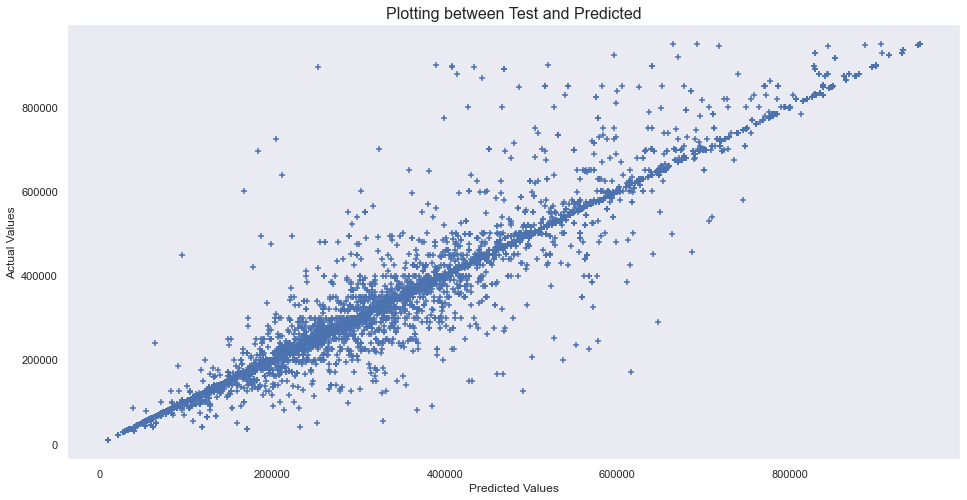

In [41]:
#print "MSE:", mean_squared_error(y_test, predicted_dm)
plt.figure(figsize=(16,8))
plt.scatter(predicted_rf, y_test, s=30, c='b', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title('Plotting between Test and Predicted',fontsize=16)
plt.show()

#### Extra Trees 

In [42]:
et = ExtraTreesRegressor()
et.fit(X_train , y_train )
predicted_et = et.predict(X_test)
print("Mean Absolute Error using Extra Trees:", mean_absolute_error(y_test, predicted_et))
print ("R^2 Extra Trees :", r2_score(y_test,predicted_et))
print(et.score(X_test, y_test))

Mean Absolute Error using Extra Trees: 5624.765702877406
R^2 Extra Trees : 0.9751979079619127
0.9751979079619127


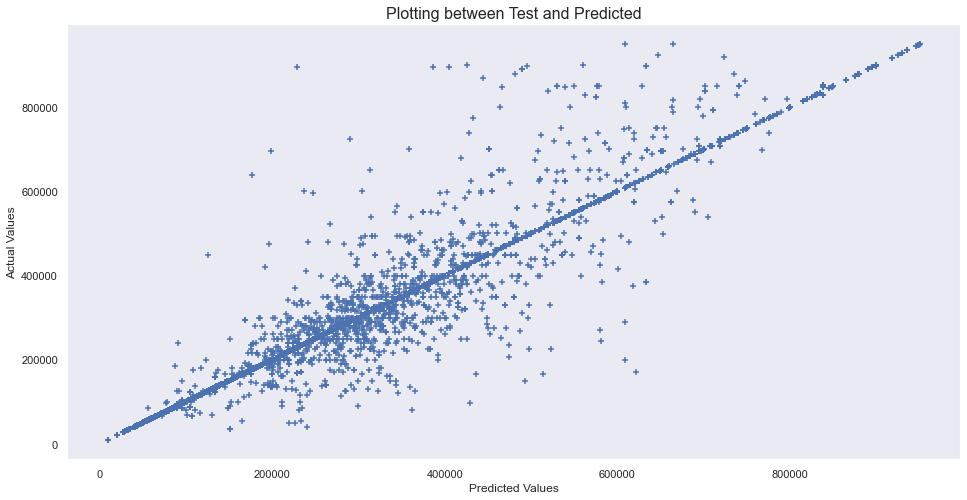

In [43]:
#print "MSE:", mean_squared_error(y_test, predicted_dm)
plt.figure(figsize=(16,8))
plt.scatter(predicted_et, y_test, s=30, c='b', marker='+')
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title('Plotting between Test and Predicted',fontsize=16)
plt.show()

### Conclusion

The score for Decision Trees, Random Forest, Extra Trees suggests that it could be overfitting. I am not sure if using the category codes was the best move, but when I tried doing the one hot encoder, using regression models took a lot of computational time due to the 4000+ features it had to go through.

In later iterations, I will have to see if there are ways to address this and also overfitting.